NBFire weather app with email 

This use the Visualcrossing weather API to demonstrate how you can parameterizwe, schedule and email notebooks on NBFire. 

To run the notebook you will need an API key from https://www.visualcrossing.com/

Please note that this notebook takes 5 parameters which we will inject at runtime via NBFire

API_KEY (For the Visual crosssing API)
LOCATION (Of the forecast)
NAME (Of the person the forecast is for)
EMAIL (Of the person the forecast is for)
GMAIL_PASSWORD (of the gmail account used to send the email (see instructions on how to obtain this password below)


The output is an email with a weather forecast table and an attached chart of the next 7 days temperature ranges for your chosen location


In [41]:
# install our dependencies. NBFire will run our notebook in a container so we need to add these packages so we can
# import them!
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install pypdf

In [42]:
# import all the packages that we need
import urllib.parse
import urllib.request
import json
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import numpy as np
from pypdf import PdfMerger

Parameters cell - values to be added in at run time via NBFire

In [43]:
API_KEY=""
NAME=""
EMAIL=""
LOCATION=""
GMAIL_PASSWORD=""
SENDER_GMAIL=""
UNIT_GROUP=""

In [44]:
# get the data from Visual Crossing
def getWeatherForecast():
         requestUrl = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/" + urllib.parse.quote_plus(LOCATION)
         requestUrl = requestUrl+"?key="+API_KEY+"&unitGroup="+UNIT_GROUP+"&include=days";
         
         print('Weather requestUrl={requestUrl}'.format(requestUrl=requestUrl))

         try:
                 req = urllib.request.urlopen(requestUrl)
         except:
                 print("Could not read from:"+requestUrl);
                 return []
                
         rawForecastData = req.read()
         req.close()
         return json.loads(rawForecastData)


In [45]:
weatherForecast = getWeatherForecast()
days=weatherForecast['days'];


Weather requestUrl=https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Glasgow?key=EWW5E6M32F6CFP3NPTGFE6MQB&unitGroup=uk&include=days


In [46]:

# create our dataframe and our html table
df = pd.DataFrame(days)
html_table=df[['datetime','description','tempmax', 'tempmin']].to_html()

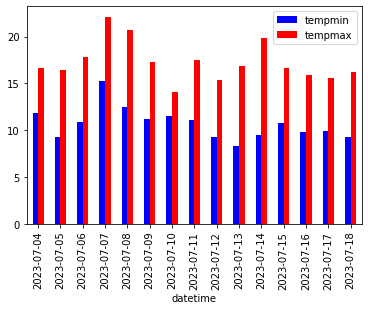

In [47]:
# plot our temp graphic and create our pdf
df.plot.bar(x='datetime', y=['tempmin', 'tempmax',], color={ "tempmin": "blue", "tempmax": "red"})
plt.savefig('graph.pdf')

In [48]:

# import the packages we need for email
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

# create the body of our text here, add the name of our recipients, the location and our weather forecast table
# note - this is HTML not plain text
body = '''Hi ''' + NAME + ''',
<br>
<br>Here is your daily weather forecast for ''' + LOCATION + '''<br><br>''' + html_table + ''' 
<br>Best wishes
<br>
<br>Fred Fish
'''
# Add the gmail address you are using to send the emails
sender = SENDER_GMAIL
# To set up the App password for a gmail account follow the instructions here https://support.google.com/mail/answer/185833?hl=en-GB
# then add it as a run time parameter on NBFire
password = GMAIL_PASSWORD
# put the email of the receiver here, I have added a copy to myself
rec_list =  [EMAIL, SENDER_GMAIL]
rec =  ', '.join(rec_list)
#Setup the MIME
message = MIMEMultipart()
message['From'] = sender
message['To'] = rec
message['Subject'] = 'Weather Report'
 
message.attach(MIMEText(body, 'html'))
 
#set the pdf we want to attach
pdfname = 'graph.pdf'

 
# open the file in bynary
binary_pdf = open(pdfname, 'rb')
 
payload = MIMEBase('application', 'octate-stream', Name=pdfname)
# payload = MIMEBase('application', 'pdf', Name=pdfname)
payload.set_payload((binary_pdf).read())
 
# enconding the binary into base64
encoders.encode_base64(payload)

# add header with pdf name
payload.add_header('Content-Decomposition', 'attachment', filename=pdfname)
message.attach(payload)
 
#use gmail with port
session = smtplib.SMTP('smtp.gmail.com', 587)
 
#enable security
session.starttls()
 
#login with mail_id and password
session.login(sender, password)
 
text = message.as_string()
session.sendmail(sender, rec_list, text)
session.quit()
print('Mail Sent')

Mail Sent
